# DECISION TREE FOR FOOD 101

# Food Image Classification for Nutritional Estimation TEST 1 using SCIKIT_LEARN

# IMPORTING LIBRARIES

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.feature_extraction.image import extract_patches_2d
from tqdm import tqdm
import pandas as pd
import random

# Check TensorFlow version
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


# LOAD FOOD101 TENSORFLOW DATASET & PRINT FIRST 10 FOOD CLASSES

In [ ]:
# Load Food-101 dataset
dataset, info = tfds.load("food101", split="train", as_supervised=True, with_info=True)

class_names = info.features["label"].names[:10]
# Get the first 10 class names

# Print information about the dataset
print("First 10 classes:", class_names)
# Print class names of the first 10 classes for confirmation


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.OUXJQN_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.OUXJQN_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
First 10 classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


# FUNCTION TO FILTER FOOD101  MATCHING THE FIRST 10 CLASS NAMES SELECTED

In [ ]:
# Function to filter dataset to only the first 10 classes

def filter_classes(image, label):
  # paremter image and label for labeling each food image class

    return label < 10
    # Keep only images where label is between 0 and 9 (first 10 classes)

# Apply filter to remove unwanted classes in FOOD 101 dataset
filtered_dataset = dataset.filter(filter_classes)

# Count dataset size to ensure same size across. SUM of all 1s
dataset_size = sum(1 for _ in filtered_dataset)

# print total images in filtered dataset
print(f"Total images in first 10 classes: {dataset_size}")

Total images in first 10 classes: 7500


# DISPLAY ONE  IMAGE PER UNIQUE FOOD CLASS

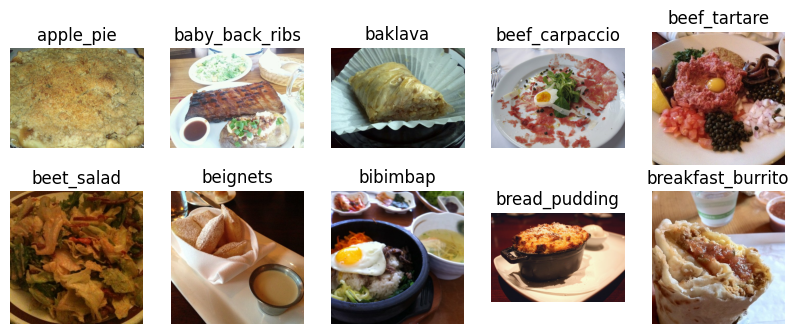

In [ ]:
# Dictionary to store one image per class
class_images = {}

# for loop to iterate through filtered 10 classes dataset
for image, label in filtered_dataset:
  # for each image and class label

    label_value = label.numpy()
    # for converting the tensorflow tensor label to python numpy integer
    # integer is need for the indexing in teh dictionary

    # interating through the dictionary storing the first images for each unique food classs label
    if label_value not in class_images:
    # if the integer as the label is not in the dictionary

        class_images[label_value] = image
        # aasign an image from the dataset corresponding uniquely to the dictionary stored food class labels

    if len(class_images) == 10:
    # Stop when we have one image per class coreresponding to each food class
        break

# Plot images
plt.figure(figsize=(10, 10))
# creating a new figure with 10 inches width and height

# iteraing over each key- value pair (class label and an image)
for i, (label, image) in enumerate(sorted(class_images.items())):
    # sorting the items in order and enumerating

    plt.subplot(5, 5, i + 1)
    # subplot in figure for 5 rows and 5 columns

    plt.imshow(image.numpy())
    # displays the image subplot
    # converting the tensorflow tensor image to python numpy integer for matplotlib

    plt.title(class_names[label])
    # sets the title of each plot to the label of each class name

    plt.axis("off")
    # removes axis ticks

plt.show()
# displays complete figure

# DATASET PREPARATION: Split into Train & Validation Sets

In [ ]:
# Define train-validation split (80-20)
train_split = 0.8
# 80% for training

train_size = int(train_split * dataset_size)
# the defined split 0.8 multiplied by the dataset size, ensured to return integer and stored in train_size variable

# Split the dataset
# train set
train_ds = filtered_dataset.take(train_size)
# take () method extracts the train_size from the filtered dataset, 80% of filtered dataset

# validation set
val_ds = filtered_dataset.skip(train_size)
# skip () method ignores the train_size from the filtered dataset, remaining 20% of filtered dataset used for validation
# remaining 20% sample from dataset

print(f"Training set size: {train_size}")
print(f"Validation set size: {dataset_size - train_size}")

Training set size: 6000
Validation set size: 1500


# DATASET PREPROCESSING: Resizing image and normalisation

In [ ]:
def preprocess(image, label):
    # Ensure the image has 3 dimensions (height, width, channels)
    if len(image.shape) == 2:  # Grayscale image (height, width)
        image = tf.expand_dims(image, axis=-1)  # Add channel dimension
    elif len(image.shape) == 3 and image.shape[-1] == 1:  # Single-channel grayscale
        image = tf.image.grayscale_to_rgb(image)  # Convert to 3 channels

    # Ensure the image has 3 channels
    if image.shape[-1] != 3:
        image = tf.image.grayscale_to_rgb(image)

    # Resize to 64x64 and normalize pixel values
    image = tf.image.resize(image, (64, 64)) / 255.0

    return image, label

# Apply preprocessing and batching
train_ds = train_ds.map(preprocess).batch(32)
val_ds = val_ds.map(preprocess).batch(32)

In [ ]:

# Check the shape of images
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("First image shape:", images[0].shape)
    print("Image data type:", images.dtype)
    print("First few pixel values:", images[0,0,0:5])

Image batch shape: (32, 64, 64, 3)
First image shape: (64, 64, 3)
Image data type: <dtype: 'float32'>
First few pixel values: tf.Tensor(
[[0.34607843 0.11862745 0.09313726]
 [0.3156863  0.1245098  0.11372549]
 [0.18333334 0.0882353  0.10098039]
 [0.6068627  0.57058823 0.622549  ]
 [0.7117647  0.6901961  0.75490195]], shape=(5, 3), dtype=float32)


# DATASET PREPROCESSING: Image Feature extraction using color histograms

### Why Color histograms for feature extraction?:
#### Color histograms capture the distribution of pixel intensities in each color channel, which is useful for characterizing the image's color properties.

In [ ]:
import numpy as np

def extract_features(dataset):
    features = []
    labels = []

    for batch_images, batch_labels in dataset:
        # Convert to numpy
        batch_images = batch_images.numpy()
        batch_labels = batch_labels.numpy()

        for i in range(len(batch_images)):
            img = batch_images[i]

            # Ensure the image has 3 channels (convert grayscale to RGB if necessary)
            if len(img.shape) == 2:  # Grayscale image (height, width)
                img = np.stack([img] * 3, axis=-1)  # Convert to 3 channels
            elif len(img.shape) == 3 and img.shape[-1] == 1:  # Single-channel grayscale
                img = np.concatenate([img] * 3, axis=-1)  # Convert to 3 channels

            # Ensure the image has the correct shape (64, 64, 3)
            if img.shape != (64, 64, 3):
                raise ValueError(f"Unexpected image shape: {img.shape}. Expected (64, 64, 3).")

            # Extract color histograms
            r_hist = np.histogram(img[:,:,0], bins=8, range=(0,1))[0]
            g_hist = np.histogram(img[:,:,1], bins=8, range=(0,1))[0]
            b_hist = np.histogram(img[:,:,2], bins=8, range=(0,1))[0]

            # Extract texture features (e.g., using edge detection)
            edges_x = np.mean(np.abs(img[:,1:] - img[:,:-1]), axis=(0,1))
            edges_y = np.mean(np.abs(img[1:,:] - img[:-1,:]), axis=(0,1))

            # Statistical features
            means = np.mean(img, axis=(0,1))
            stds = np.std(img, axis=(0,1))

            # Combine all features
            img_features = np.concatenate([r_hist, g_hist, b_hist, edges_x, edges_y, means, stds])

            features.append(img_features)
            labels.append(batch_labels[i])

    return np.array(features), np.array(labels)
# Extract features
X_train, y_train = extract_features(train_ds)
X_val, y_val = extract_features(val_ds)

# Train the decision tree

In [ ]:
# Measure training time for runtime performance
start_time = time.time()

# Create and train decision tree
dt_classifier = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_classifier.fit(X_train, y_train)

# Calculate training time
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f} seconds")

Training time: 0.31 seconds


# Predictions and calculation metrics


In [ ]:
from sklearn.metrics import log_loss

# Measure inference time
inference_start = time.time()

# Make predictions
y_train_pred = dt_classifier.predict(X_train)
y_val_pred = dt_classifier.predict(X_val)

# For accuracy-loss graph, we need probabilities
y_train_prob = dt_classifier.predict_proba(X_train)
y_val_prob = dt_classifier.predict_proba(X_val)

inference_time = time.time() - inference_start
print(f"Inference time: {inference_time:.2f} seconds")

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Calculate loss (cross-entropy loss)
train_loss = log_loss(y_train, y_train_prob)
val_loss = log_loss(y_val, y_val_prob)

print(f"Train accuracy: {train_accuracy:.4f}, Train loss: {train_loss:.4f}")
print(f"Validation accuracy: {val_accuracy:.4f}, Validation loss: {val_loss:.4f}")

# Get classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=class_names))

# Calculate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

Inference time: 0.01 seconds
Train accuracy: 0.5015, Train loss: 1.3818
Validation accuracy: 0.2280, Validation loss: 9.9641

Classification Report:
                   precision    recall  f1-score   support

        apple_pie       0.18      0.16      0.17       152
   baby_back_ribs       0.22      0.33      0.26       135
          baklava       0.23      0.23      0.23       138
   beef_carpaccio       0.19      0.17      0.18       155
     beef_tartare       0.23      0.22      0.22       157
       beet_salad       0.25      0.24      0.24       144
         beignets       0.31      0.22      0.26       170
         bibimbap       0.44      0.37      0.40       166
    bread_pudding       0.14      0.18      0.16       144
breakfast_burrito       0.14      0.16      0.15       139

         accuracy                           0.23      1500
        macro avg       0.23      0.23      0.23      1500
     weighted avg       0.24      0.23      0.23      1500



# Visualize metrics: Accuracy and loss

(0.0, 10.960486797588208)

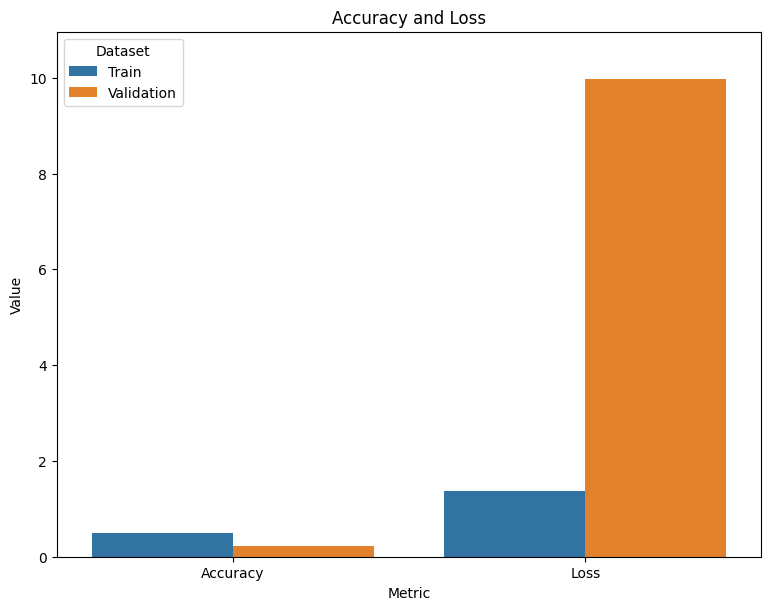

In [ ]:

# Create a figure with subplots
plt.figure(figsize=(20, 15))

# 1. Plot accuracy and loss
plt.subplot(2, 2, 1)
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Loss'],
    'Train': [train_accuracy, train_loss],
    'Validation': [val_accuracy, val_loss]
})
metrics_melted = pd.melt(metrics, id_vars=['Metric'], var_name='Dataset', value_name='Value')
sns.barplot(x='Metric', y='Value', hue='Dataset', data=metrics_melted)
plt.title('Accuracy and Loss')
plt.ylim(0, max(train_loss, val_loss) * 1.1)  # Adjust y-axis for loss scale

# Visualize metrics: Confusion matrix

Text(0.5, 765.5815972222223, 'Predicted Label')

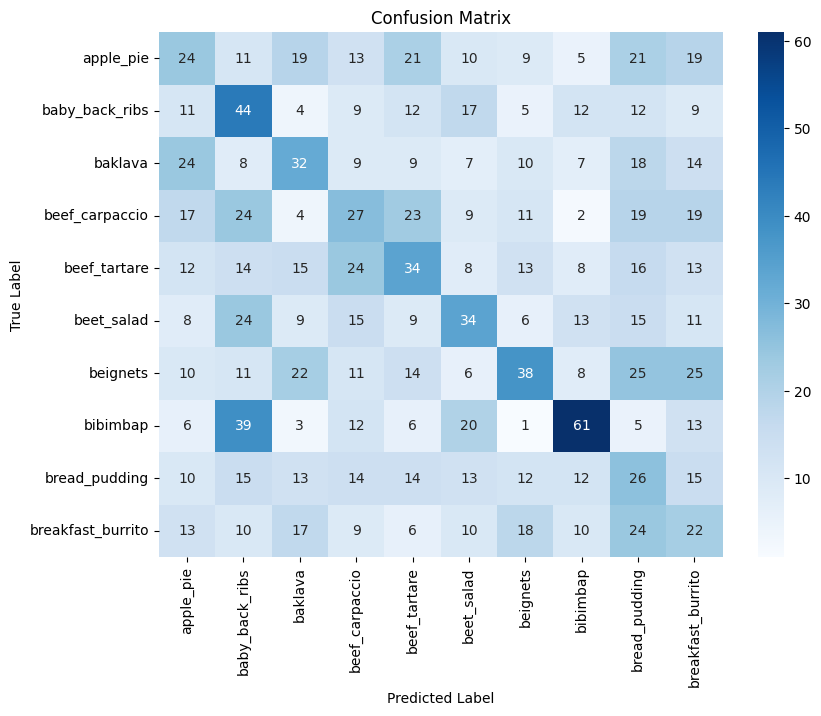

In [ ]:
# 2. Plot confusion matrix
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Visualize metrics: Precision, Recall, f1-score

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'apple_pie'),
  Text(1, 0, 'baby_back_ribs'),
  Text(2, 0, 'baklava'),
  Text(3, 0, 'beef_carpaccio'),
  Text(4, 0, 'beef_tartare'),
  Text(5, 0, 'beet_salad'),
  Text(6, 0, 'beignets'),
  Text(7, 0, 'bibimbap'),
  Text(8, 0, 'bread_pudding'),
  Text(9, 0, 'breakfast_burrito')])

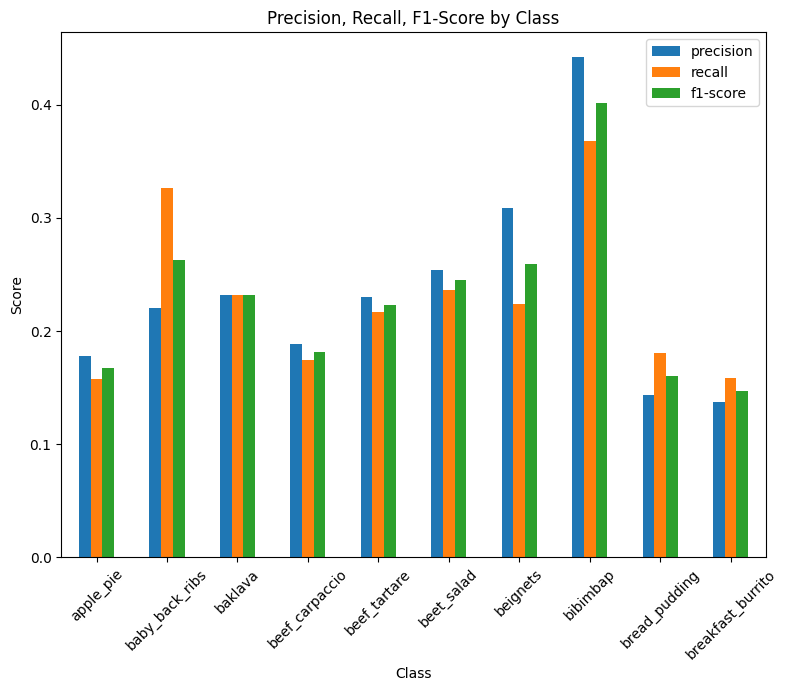

In [ ]:
# 3. Plot precision, recall, f1-score
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 3)
# Convert classification report to DataFrame
report_dict = classification_report(y_val, y_val_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).T
report_df = report_df.iloc[:-3]  # Remove avg rows
metrics_df = report_df[['precision', 'recall', 'f1-score']]
metrics_df.plot(kind='bar', ax=plt.gca())
plt.title('Precision, Recall, F1-Score by Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(rotation=45)

# Visualize metrics: Plot runtime performance

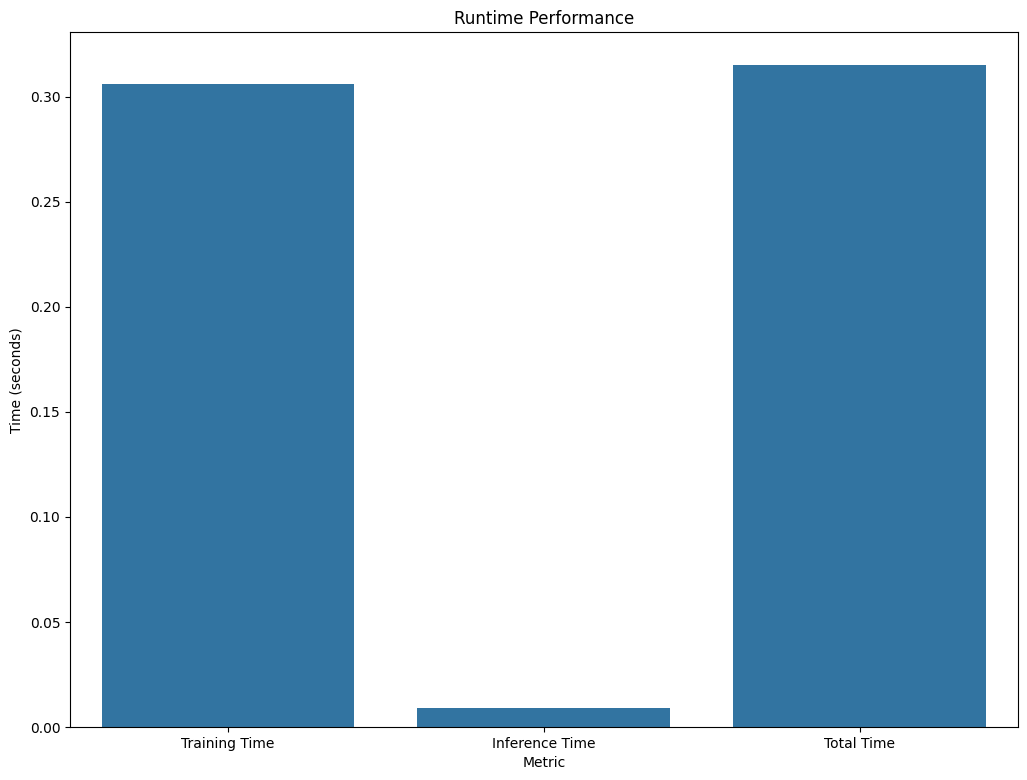

In [ ]:
# 4. Plot runtime performance
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 4)
performance = pd.DataFrame({
    'Metric': ['Training Time', 'Inference Time', 'Total Time'],
    'Time (seconds)': [train_time, inference_time, train_time + inference_time]
})
sns.barplot(x='Metric', y='Time (seconds)', data=performance)
plt.title('Runtime Performance')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

# Visualize metrics: Depth vs. Accuracy plot (to tune the model)

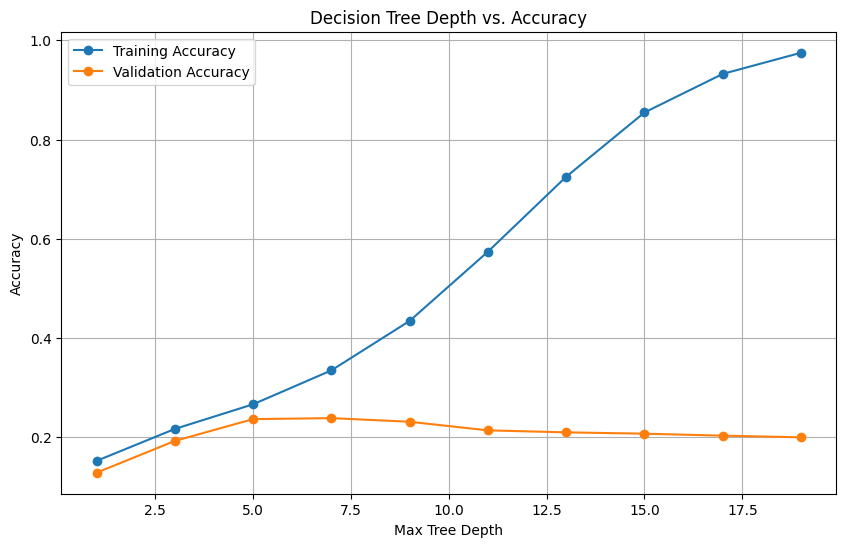

In [ ]:
# 5. Depth vs. Accuracy plot (to tune the model)
# This shows how accuracy changes with tree depth
max_depths = range(1, 20, 2)
train_scores = []
val_scores = []

for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, dt.predict(X_train)))
    val_scores.append(accuracy_score(y_val, dt.predict(X_val)))

plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_scores, 'o-', label='Training Accuracy')
plt.plot(max_depths, val_scores, 'o-', label='Validation Accuracy')
plt.xlabel('Max Tree Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Depth vs. Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Runtime Performance Summary

In [ ]:
# Runtime performance summary
runtime_summary = {
    'Total Images': len(y_train) + len(y_val),
    'Training Time (s)': train_time,
    'Inference Time (s)': inference_time,
    'Images per Second (Training)': len(y_train) / train_time,
    'Images per Second (Inference)': len(y_val) / inference_time
}

print("\nRuntime Performance Summary:")
for key, value in runtime_summary.items():
    print(f"{key}: {value}")


Runtime Performance Summary:
Total Images: 7500
Training Time (s): 0.3058788776397705
Inference Time (s): 0.009125947952270508
Images per Second (Training): 19615.60747933082
Images per Second (Inference): 164366.48640175562
